# RAFT IVF-PQ tutorial
In this tutorial you will learn to build IVF-PQ index and use it to search approximate nearest neighbors (ANN).

In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# A clumsy helper for inspecting properties of an object
def show_properties(obj):
    return {
        attr: getattr(obj, attr)
        for attr in dir(obj)
        if type(getattr(type(obj), attr)).__name__ == 'getset_descriptor'
    }

In [3]:
# We'll need to load store some data in this tutorial
import os
import tempfile

WORK_FOLDER = os.path.join(tempfile.gettempdir(), 'raft_ivf_pq_tutorial')

if not os.path.exists(WORK_FOLDER):
   os.makedirs(WORK_FOLDER)
print("The index and data will be saved in", WORK_FOLDER)

The index and data will be saved in /tmp/raft_ivf_pq_tutorial


## Get the data
We're going to use the data from [ANN benchmarks website](https://ann-benchmarks.com),
which provides a few datasets in [HDF5 format](https://www.hdfgroup.org/solutions/hdf5/).

The list of prepared dataset can be found at https://github.com/erikbern/ann-benchmarks/#data-sets

In [4]:
DATASET_URL = "http://ann-benchmarks.com/sift-128-euclidean.hdf5"
DATASET_FILENAME = DATASET_URL.split('/')[-1]

## download the dataset
import urllib.request
dataset_path = os.path.join(WORK_FOLDER, DATASET_FILENAME)
if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(DATASET_URL, dataset_path)

## Load the dataset

In [5]:
import h5py
f = h5py.File(dataset_path, "r")

metric = f.attrs['distance']

dataset = cp.array(f['train'])
queries = cp.array(f['test'])
gt_neighbors = cp.array(f['neighbors'])
gt_distances = cp.array(f['distances'])

print(f"Loaded dataset of size {dataset.shape}; metric: '{metric}'.")
print(f"Number of test queries: {queries.shape[0]}")

Loaded dataset of size (1000000, 128); metric: 'euclidean'.
Number of test queries: 10000


## Build the index
Construction of the index generally consists of two phases: training (building the clusters) and filling-in (extending the index with data).
In the first phase, a balanced hierarchical k-means algorithm clusters the training data.
In the second phase, the new data is classified and added into the appropriate clusters in the index.
Hence, a user should call `ivf_pq.build` once and then possibly `ivf_pq.extend` several times.
Though for user convenience `ivf_pq.build` by default adds the whole training set into the index.

In [6]:
# RAFT's DeviceResources controls the GPU, cuda stream, memory policies etc.
# For now, we just create a default instance.
from pylibraft.common import DeviceResources
resources = DeviceResources()

In [7]:
from pylibraft.neighbors import ivf_pq
# First, we need to initialize the build/indexing parameters.
# One of the more important parameters is the product quantisation (PQ) dim.
# Effectively, this parameter says
#      "shrink the dataset to this dimensionality to reduce the index size".
# It must be not bigger than the dataset dim,
# and it should be divisible by 32 for better GPU performance.
pq_dim = 1
while pq_dim * 2 < dataset.shape[1]:
    pq_dim = pq_dim * 2
# We'll use the ANN-benchmarks-provided metric and sensible defaults for the rest of parameters.
index_params = ivf_pq.IndexParams(n_lists=1024, metric=metric, pq_dim=pq_dim)

show_properties(index_params)

{'add_data_on_build': True,
 'codebook_kind': 0,
 'conservative_memory_allocation': False,
 'force_random_rotation': False,
 'kmeans_n_iters': 20,
 'kmeans_trainset_fraction': 0.5,
 'metric': 1,
 'n_lists': 1024,
 'pq_bits': 8,
 'pq_dim': 64}

In [8]:
%%time
## Build the index
# This function takes a row-major either numpy or cupy (GPU) array.
# Generally, it's a bit faster with GPU inputs, but the CPU version may come in handy
# if the whole dataset cannot fit into GPU memory (or even CPU RAM -- use mmap for that).
index = ivf_pq.build(index_params, dataset, handle=resources)
# Sync the GPU to make sure we've got the timing right
resources.sync()
index

CPU times: user 3.69 s, sys: 727 ms, total: 4.42 s
Wall time: 4.41 s


Index(type=IVF-PQ, metric=euclidean, codebook=subspace, size=1000000, dim=128, pq_dim=64, pq_bits=8, n_lists=1024, rot_dim=128)

## Search
The search function returns the requested number `k` of (approximate) nearest neighbor in no particular order.
Besides the queries and `k`, the function can take a few more parameters to tweak the performance of the algorithm.
Again, these are passed via the struct with some sensible defaults.

In [9]:
k = 10
search_params = ivf_pq.SearchParams()
show_properties(search_params)

{'internal_distance_dtype': 0, 'lut_dtype': 0, 'n_probes': 20}

In [10]:
%%time
distances, neighbors = ivf_pq.search(search_params, index, queries, k, handle=resources)
# Sync the GPU to make sure we've got the timing right
resources.sync()

CPU times: user 49.1 ms, sys: 16.1 ms, total: 65.2 ms
Wall time: 65 ms


In [11]:
## Check the quality of the prediction (recall)
def calc_recall(found_indices, ground_truth):
    found_indices = cp.asarray(found_indices)
    bs, k = found_indices.shape
    if bs != ground_truth.shape[0]:
        raise RuntimeError(
            "Batch sizes do not match {} vs {}".format(
                bs, ground_truth.shape[0])
        )
    if k > ground_truth.shape[1]:
        raise RuntimeError(
            "Not enough indices in the ground truth ({} > {})".format(
                k, ground_truth.shape[1])
        )
    n = 0
    # Go over the batch
    for i in range(bs):
        # Note, ivf-pq does not guarantee the ordered input, hence the use of intersect1d
        n += cp.intersect1d(found_indices[i, :k], ground_truth[i, :k]).size
    recall = n / found_indices.size
    return recall

recall_first_try = calc_recall(neighbors, gt_neighbors)
print(f"Got recall = {recall_first_try} with the default parameters (k = {k}).")

Got recall = 0.85257 with the default parameters (k = 10).


## Refine
Let's improve our results a little bit!
The refinement operation follows an approximate NN search.
It recomputes the exact distances for the already selected candidates and selects a subset of them thus improving the recall.

In [12]:
from pylibraft.neighbors import refine

In [13]:
%%time

candidates = ivf_pq.search(search_params, index, queries, k * 2, handle=resources)[1]
distances, neighbors = refine(dataset, queries, candidates, k, handle=resources)
resources.sync()

CPU times: user 206 ms, sys: 21.9 ms, total: 228 ms
Wall time: 228 ms


In [14]:
recall_refine2x = calc_recall(neighbors, gt_neighbors)
print(f"Got recall = {recall_refine2x} with 2x refinement (k = {k}).")

Got recall = 0.94913 with 2x refinement (k = 10).


## Tweaking search parameters

#### Number of neighbors
Let see how QPS depens on `k`. 

33.5 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.4 ms ± 52.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.3 ms ± 41.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.2 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.1 ms ± 88.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.4 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
47 ms ± 794 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
67.7 ms ± 448 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
90.3 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
105 ms ± 736 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


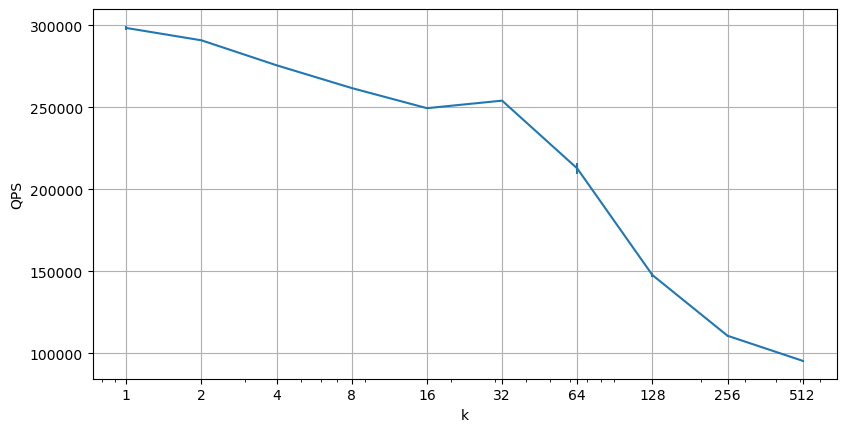

In [15]:
bench_k = np.exp2(np.arange(10)).astype(np.int32)
bench_avg = np.zeros_like(bench_k, dtype=np.float32)
bench_std = np.zeros_like(bench_k, dtype=np.float32)
for i, k in enumerate(bench_k):
    r = %timeit -o ivf_pq.search(search_params, index, queries, k, handle=resources); resources.sync()
    bench_avg[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_std[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).std()

fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
ax.errorbar(bench_k, bench_avg, bench_std)
ax.set_xscale('log')
ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('k')
ax.grid()
ax.set_ylabel('QPS');

#### Number of probes
IVF-PQ search runs in two phases; first it looks for nearest clusters,
then it searches for the neighbors in every selected cluster.

We can set how many clusters we want to inspect.
For this, `ivf_pq.SearchParams` has a parameter `n_probes`.
This is the core parameter control the QPS/recall trade-off.

In [16]:
bench_probes = np.exp2(np.arange(11)).astype(np.int32)
bench_qps = np.zeros_like(bench_probes, dtype=np.float32)
bench_recall = np.zeros_like(bench_probes, dtype=np.float32)
k = 100
for i, n_probes in enumerate(bench_probes):
    sp = ivf_pq.SearchParams(n_probes=n_probes)
    r = %timeit -o ivf_pq.search(sp, index, queries, k, handle=resources); resources.sync()
    bench_qps[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_recall[i] = calc_recall(ivf_pq.search(sp, index, queries, k, handle=resources)[1], gt_neighbors)
    

8.44 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.7 ms ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.2 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
26.9 ms ± 34.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.4 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
105 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
193 ms ± 552 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
370 ms ± 605 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
758 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.38 s ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.55 s ± 566 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


It's clear that the search time scales almost linearly with the number of probes.
This is due to the algorithm spending most of the time in the second phase scanning through individual clusters.
Thanks to the balanced nature of the clustering k-means algorithm, the sizes of the clusters are roughly similar;
hence the linear relation `n_probes` ~ query time.

Let's draw some plots to illustrate how the number of probes affects QPS and recall.

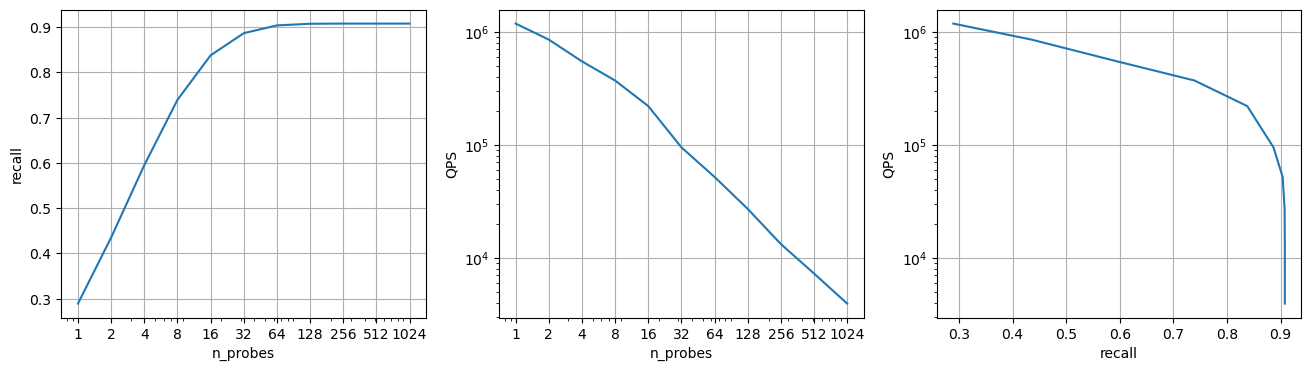

In [17]:
fig, ax = plt.subplots(1, 3, figsize=plt.figaspect(1/4))

ax[0].plot(bench_probes, bench_recall)
ax[0].set_xscale('log')
ax[0].set_xticks(bench_probes, bench_probes)
ax[0].set_xlabel('n_probes')
ax[0].set_ylabel('recall')
ax[0].grid()

ax[1].plot(bench_probes, bench_qps)
ax[1].set_xscale('log')
ax[1].set_xticks(bench_probes, bench_probes)
ax[1].set_xlabel('n_probes')
ax[1].set_ylabel('QPS')
ax[1].set_yscale('log')
ax[1].grid()

ax[2].plot(bench_recall, bench_qps)
ax[2].set_xlabel('recall')
ax[2].set_ylabel('QPS')
ax[2].set_yscale('log')
ax[2].grid();

#### Internal search types
Besides `n_probes`, `ivf_pq.SearchParams` contains couple more parameters, which affect internal workings of the algorithm.

`internal_distance_dtype` controls the representation of the distance/similarity during the search.
By default, it's `np.float32`, but you can change it to `np.float16` when appropriate to save the memory bandwidth.
This can be a good idea when the dataset type is low precision anyway (e.g. `np.uint8`),
yet it may help with 32-bit float datasets too.

`lut_dtype` is the Look-Up Table Data Type.
The specifics of the PQ algorithm is that it stores the data in the Product Quantizer (PQ) encoded format,
which needs to be decoded during the second-phase (in-cluster) search.
Thus, the algorithm constructs a lookup table for each cluster.
This is a costly operation, and the table itself can be rather large.
By default, the individual elements in the table are stored as 32-bit floats,
but you can change this to `np.float16` or `np.uint8` to reduce the table size.

The exact size of the table is as follows:

$ \mathtt{lut\_size} = \mathtt{pq\_dim} \cdot \mathtt{sizeof(lut\_dtype) \cdot 2^{\mathtt{pq\_bits}}} $

Ideally, the lookup table should fit in the shared memory of a GPU's multiprocessor,
but it's not the case for wider datasets.
The logic of deciding whether this table should stay in the shared or the global memory of the GPU is somewhat complicated.
Yet, you can see the outcome when you gradually change `pq_dim` and observe a sudden drop in QPS after a certain threshold.
The shared-memory kernel version is typically 2-5x faster than the global-memory version.

However `pq_dim` strongly affects the recall and requires the index to be re-build on change.
This is where `lut_dtype` comes in handy: you can halve or quarter the lookup table size by changing it.
Though it does affect the recall too.

Also note, it does not make sense to set the `lut_dtype` to a more precise type than `internal_distance_dtype`,
as the former is converted to the latter internally.


In [18]:
bench_qps = np.zeros((5,), dtype=np.float32)
bench_recall = np.zeros((5,), dtype=np.float32)
k = 100
n_probes = 256
search_params_32_32 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float32, lut_dtype=np.float32)
search_params_32_16 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float32, lut_dtype=np.float16)
search_params_32_08 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float32, lut_dtype=np.uint8)
search_params_16_16 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float16, lut_dtype=np.float16)
search_params_16_08 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float16, lut_dtype=np.uint8)
search_ps = [search_params_32_32, search_params_32_16, search_params_32_08, search_params_16_16, search_params_16_08]
bench_names = ['32/32', '32/16', '32/8', '16/16', '16/8']

for i, sp in enumerate(search_ps):
    r = %timeit -o ivf_pq.search(sp, index, queries, k, handle=resources); resources.sync()
    bench_qps[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_recall[i] = calc_recall(ivf_pq.search(sp, index, queries, k, handle=resources)[1], gt_neighbors)

704 ms ± 896 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
598 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
458 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
420 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
354 ms ± 914 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


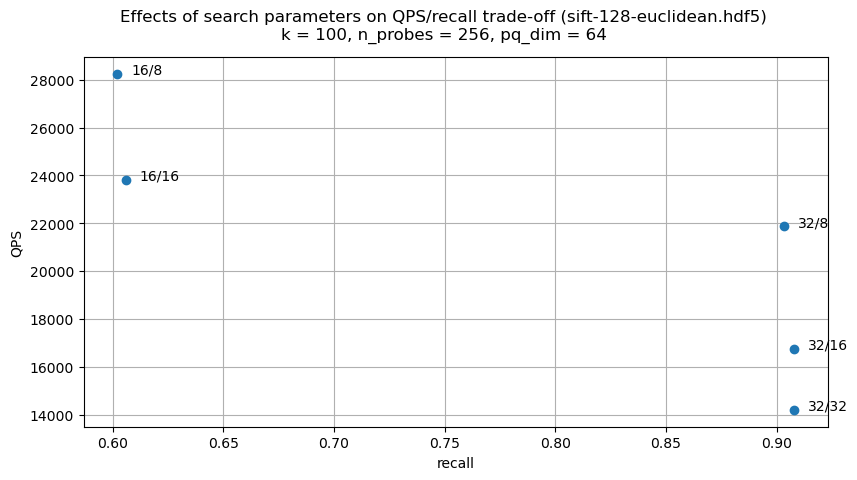

In [19]:
fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
fig.suptitle(
    f'Effects of search parameters on QPS/recall trade-off ({DATASET_FILENAME})\n' + \
    f'k = {k}, n_probes = {n_probes}, pq_dim = {pq_dim}')
ax.plot(bench_recall, bench_qps, 'o')
ax.set_xlabel('recall')
ax.set_ylabel('QPS')
ax.grid()
for i, label in enumerate(bench_names):
    ax.annotate(
        label,
        (bench_recall[i], bench_qps[i]),
        textcoords="offset points",
        xytext=(10,0),
        ha='left') 

Depending on the GPU and the selected dataset, you may see different pictures.
With SIFT-128 (`pq_dim = 64`), reducing the `internal_distance_dtype` comes at a huge cost to recall,
whereas `lut_dtype` doesn't cost too much while significantly improving QPS.


Let's try the same experiment, but with refinement.
We'll try ratio 2 and 4 and see how it affects recall and QPS.

In [20]:
def search_refine(ps, ratio):
    k_search = k * ratio
    candidates = ivf_pq.search(ps, index, queries, k_search, handle=resources)[1]
    return candidates if ratio == 1 else refine(dataset, queries, candidates, k, handle=resources)[1]

ratios = [1, 2, 4]
bench_qps = np.zeros((len(ratios), len(search_ps)), dtype=np.float32)
bench_recall = np.zeros((len(ratios), len(search_ps)), dtype=np.float32)

for j, ratio in enumerate(ratios): 
    for i, ps in enumerate(search_ps):
        r = %timeit -o search_refine(ps, ratio);  resources.sync()
        bench_qps[j, i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
        bench_recall[j, i] = calc_recall(search_refine(ps, ratio), gt_neighbors)

705 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
553 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
439 ms ± 506 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
418 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
354 ms ± 846 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
793 ms ± 7.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
734 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
699 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
684 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
655 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
877 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
829 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
792 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
689 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
661 ms ± 795 µs per loop (mean ± std. dev. of 7 runs

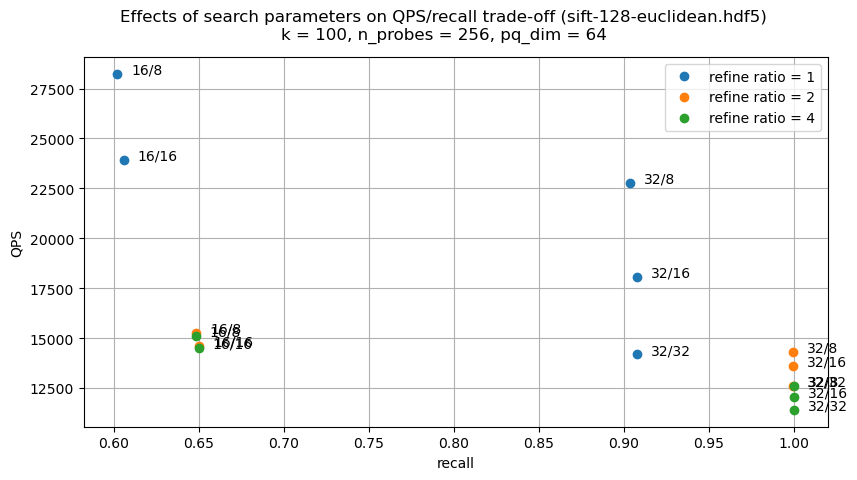

In [21]:
fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
fig.suptitle(
    f'Effects of search parameters on QPS/recall trade-off ({DATASET_FILENAME})\n' + \
    f'k = {k}, n_probes = {n_probes}, pq_dim = {pq_dim}')
labels = []
for j, ratio in enumerate(ratios):
    ax.plot(bench_recall[j, :], bench_qps[j, :], 'o')
    labels.append(f"refine ratio = {ratio}")
ax.legend(labels)
ax.set_xlabel('recall')
ax.set_ylabel('QPS')
ax.grid()
for j, ratio in enumerate(ratios):
    for i, label in enumerate(bench_names):
        ax.annotate(
            label,
            (bench_recall[j, i], bench_qps[j, i]),
            textcoords="offset points",
            xytext=(10,0),
            ha='left')

Depending on the dataset, you may see very different pictures here; for SIFT-128, we would pick three winning candidates along the Pareto curve:
  - `internal_distance_dtype = 16, lut_dtype = 8`
  - `internal_distance_dtype = 32, lut_dtype = 8`
  - `internal_distance_dtype = 32, lut_dtype = 8, refine_ratio = 2`

This is all for the search parameters, but we will come back to the look-up table question in the next section.

In [22]:
def search_refine(internal_distance_dtype, ratio, n_probes):
    k_search = k * ratio
    ps = ivf_pq.SearchParams(
        n_probes=n_probes,
        internal_distance_dtype=internal_distance_dtype,
        lut_dtype=np.uint8)
    candidates = ivf_pq.search(ps, index, queries, k_search, handle=resources)[1]
    return candidates if ratio == 1 else refine(dataset, queries, candidates, k, handle=resources)[1]

search_configs = [
    lambda n_probes: search_refine(np.float16, 1, n_probes),
    lambda n_probes: search_refine(np.float32, 1, n_probes),
    lambda n_probes: search_refine(np.float32, 2, n_probes)
]
search_config_names = [
    '16/8', '32/8', '32/8/r2'
]

## Tweaking indexing parameters


Deciding on the indexing parameters is a bit more involved than on the search parameters. This is obviously because `ivf_pq.IndexParams` has more members than `ivf_pq.SearchParams`, but also because the try-test loop takes longer time when it includes training. Luckily training raft's ivf-pq does not take too much time thanks to using its fast implementation of Balanced Hierarchical K-Means clustering during build and an efficient encoding kernel.

First of all, let's pick the parameters we __don't need__ to tweak:

  - `metric` - the distance metric often depens on the problem and thus fixed (currently raft supports variations of eucliean and inner product distances)
  - `conservative_memory_allocation` only affects how data is allocated - does not affect the search performance
  - `add_data_on_build` is a convenience flag that tells if you prefer to do both training (clustering) and filling the DB in one call to `ivf_pq.build` or start with an empty DB and add all data using `ivf_pq.extend`
  - `force_random_rotation` may slightly affect performance when the data dimensionality is a power of two (see the module docs), but normally you don't need to change the defaults. 

The rest of the parameters can be divided in two categories: influencing the coarse search (`kmeans_n_iters`, `kmeans_trainset_fraction` , `n_lists`) and the fine search / product quantization (`codebook_kind`, `pq_dim`, `pq_bits`).

### Indexing parameters affecting the coarse search

#### n_lists

`n_lists` is the first parameter to look at. It has a profound impact on overall performance during both training and search.
`n_lists` defines the number of clusters into which the index data is partitioned; you should keep this in mind when selecting the `n_probes` search parameter.

The ratio `n_probes/n_lists` tells how large fraction of the dataset is compared to each query. If `n_lists == n_probes`, that is like a brute force search: we compare all dataset vectors to all query vectors. One would expect the recall is equal to `1` in such a case, but that does not take into account the PQ compression; in reality the recall is always lower unless you refine the search results.

As `n_probes` approaches `n_lists`, IVF-PQ becomes slower than brute force because of all the extra work the algorithm does: dimension padding / transform, two-step search, extra PQ compute, etc. In practice searching around 1% of lists is enough for many datasets. But this depends on how well the input can be clustered. (e.g. for uniform random numbers as inputs, IVF methods don't work well).

`n_lists = sqrt(n_samples)` is a good starting point for the balance of coarse/fine search time. To make sure the GPU resources are utilized efficiently, keep in mind:
  - The average cluster size (i.e. n_smaples / n_lists) should be in the range of at least ~2k records to keep individual SMs busy
  - Total amount of search work (n_queries * n_probes) should be a good multiple of number of SMs


In [26]:
n_list_variants = [100, 500, 1000, 2000, 5000]
pl_ratio_variants = [500, 200, 100, 50, 10, 5]
selected_search_variant = 1
search_fun = search_configs[selected_search_variant]
search_label = search_config_names[selected_search_variant]

bench_qps = np.zeros((len(n_list_variants), len(pl_ratio_variants)), dtype=np.float32)
bench_recall = np.zeros_like(bench_qps, dtype=np.float32)

for i, n_lists in enumerate(n_list_variants):
    index_params = ivf_pq.IndexParams(n_lists=n_lists, metric=metric, pq_dim=pq_dim)
    index = ivf_pq.build(index_params, dataset, handle=resources)
    for j, pl_ratio in enumerate(pl_ratio_variants):
        n_probes = max(1, n_lists // pl_ratio)
        r = %timeit -o search_fun(n_probes);  resources.sync()
        bench_qps[i, j] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
        bench_recall[i, j] = calc_recall(search_fun(n_probes), gt_neighbors)

17.8 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.7 ms ± 52.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
18 ms ± 74.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
33 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
130 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
98.7 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.99 ms ± 32.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.7 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.1 ms ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
112 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
210 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.4 ms ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.4 ms ± 49.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
27 ms ± 524 µs 

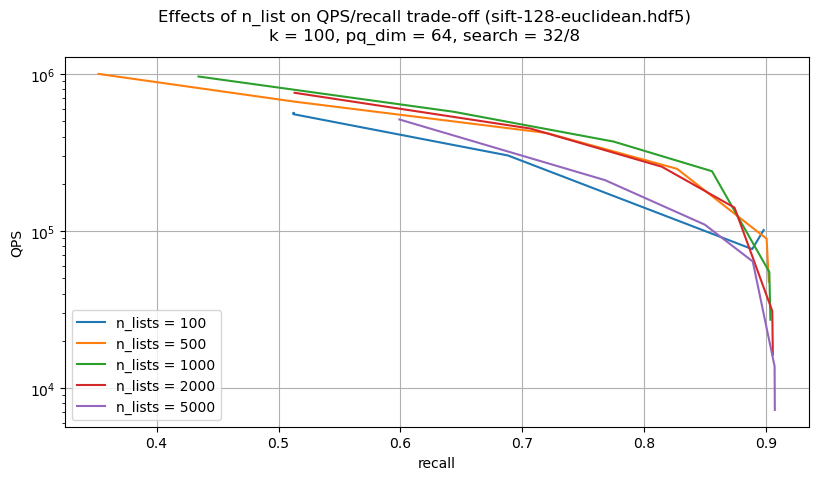

In [27]:
fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
fig.suptitle(
    f'Effects of n_list on QPS/recall trade-off ({DATASET_FILENAME})\n' + \
    f'k = {k}, pq_dim = {pq_dim}, search = {search_label}')
labels = []
for i, n_lists in enumerate(n_list_variants):
    ax.plot(bench_recall[i, :], bench_qps[i, :])
    labels.append(f"n_lists = {n_lists}")

ax.legend(labels)
ax.set_xlabel('recall')
ax.set_ylabel('QPS')
ax.set_yscale('log')
ax.grid()

For the given data set (SIFT-128) and the selected parameters, one can see that 5000 clusters is clearly too much, while the index with 100 clusters behaves just weird. In the range of 500-2000 the algorithm performs very similar though.
Hence, you shouldn't worry about finding the exact single best value of `n_lists`, but rather make sure it's within a reasonable range.


#### kmeans_trainset_fraction

This parameter defines how much of the original data should be fed into training.
This is useful when in conjugation with `add_data_on_build = True`.
For example, having a 100M-record dataset, it's reasonable to set `kmeans_trainset_fraction = 0.1` to train the index (i.e. run the k-means clustering) using 10M records only (10% of data), and then add the whole dataset to the index.
Hence, this parameter directly affects the training speed, but can indirectly affect the search performance (depending on how well the training set represents the full dataset).

#### kmeans_n_iters

This parameter is passed directly to the k-means algorithm during training. It's set to a reasonable default of 20, which works for most datasets. However, once in a while you may see a warning complaining that the trained clusters are imbalanced. You can try to fix that by increasing the number of iterations.

### Indexing parameters affecting the fine search / product quantization

TODO: codebook_kind, pq_dim, pq_bits

NOTES:

Apart from that the trends look as expected to me:
  - increasing nbits has a visible trend,
  - increasing nprobes has improves recall initially, but quickly saturates due to quantization error (due to low pq_dim)
  - for nlist it is hard to see trend here alone because nprobes/nlist ratio matters.

The product quantization parameters (pq_dim and pq_bits):
  - I would start with pq_dim = n_features and pq_bits=8 (i.e minimal quantization loss) just to confirm that the coarse search parameters are reasonable.
  - experiment with pq_dim=64, 48, 32 (in general values in range [n_features, n_features/2]) and variations of pq_bits
